# Outlier detection with Local Outlier Factor

---------

**[contens]**

1. Generate Data  
2. Calculate LOF  
3. K-neighborhood Result   
    3.0 Grid Search Result    
    3.1 통계적 변동성에 따른 선택   
    3.2 데이터 특성에 따른 선택

In [1]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.neighbors import LocalOutlierFactor

SEED = 42

## 1. Generate Data

In [3]:
X,y = make_blobs(n_samples = 1000,
                centers =3,
                n_features = 2,
                random_state= SEED)

(1050, 2)


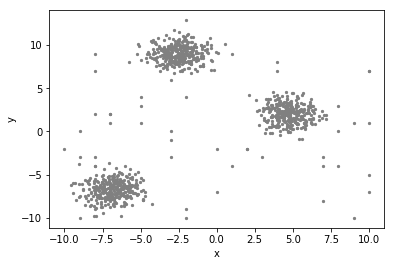

In [4]:
random.seed(SEED)
random_pts = []
for i in range(50):
    random_pts.append([random.randint(-10,10),
                       random.randint(-10,10)])
    
X = np.append(X, random_pts, axis = 0)
print(X.shape)
DF = pd.DataFrame(dict(x=X[:,0], y = X[:,1]))
DF.plot(kind = 'scatter',
        x = 'x', y = 'y',
       color = 'gray',
       s = 5)
plt.show()

-----
## 2. LOF 계산
현재 데이터에 적정한 k_neighbors를 선정하기 위해 grid search를 진행합니다. contamination을 auto로 지정해둘 경우, original paper에 나온 threshold로 정의합니다. 하지만, 여기서 threshold로 정해진 예측값을 사용하는 것이 아니므로 무엇으로 지정되어있든 상관이 없습니다.   

  LOF Score는 실제 논문상 Inlier일수록 1에 가깝고, Oulier일수록 1과 멀고 큰 값을 갖습니다. Sklearn의 LOF는 음수값을 붙여서 제공하므로 -를 붙여서 결과를 산출합니다.

In [5]:
lof_clf = LocalOutlierFactor(n_neighbors =20,
                            novelty = False,
                            contamination = 'auto')
lof_clf.fit_predict(X)

array([ 1,  1,  1, ..., -1, -1, -1])

In [6]:
lof_score = -lof_clf.negative_outlier_factor_
lof_score

array([0.96509716, 0.98052902, 1.02702723, ..., 3.30632075, 1.88119997,
       2.59633323])

 -----
## 3. K-Neighborhood 선택방법 </br>
### 3.0 Grid Search Result
 최적 k를 설정하기 위해 **grid search**결과를 제공합니다.

In [14]:
totDF = pd.DataFrame()
for num, kNeighbor in enumerate([2,3,4,5,6,7,8,9,10]):
    print(num, end = ', ')
    lof_clf = LocalOutlierFactor(
                    n_neighbors = kNeighbor,
                    novelty = False,
                    contamination = 'auto'
                    )
    lof_clf.fit_predict(X)
    lof_score = -lof_clf.negative_outlier_factor_
    rDF = pd.DataFrame({'lof_score': lof_score, 
                        'data_index': DF.index})
    rDF.loc[:, 'k'] = kNeighbor
    
    totDF = pd.concat([totDF, rDF], axis = 0)
    

0, 1, 2, 3, 4, 5, 6, 7, 8, 

In [15]:
print(totDF.shape)
totDF.head(3)

(9450, 3)


,lof_score,data_index,k
0,0.922739,0,2
1,0.967393,1,2
2,1.256972,2,2


-----

### 3.1 통계적 변동성에 따른 선택(Statistic Fluctuation) </br>
통계적으로 변동성이 적어지는 지점을 선택합니다.

In [16]:
plotDF = totDF.copy()

sumDF  = plotDF.groupby('k')['lof_score'].describe()

kL   = sumDF.index.tolist()
minL = sumDF['min'].tolist()
meanL= sumDF['mean'].tolist()
maxL = sumDF['max'].tolist()
stdL = sumDF['std'].tolist()

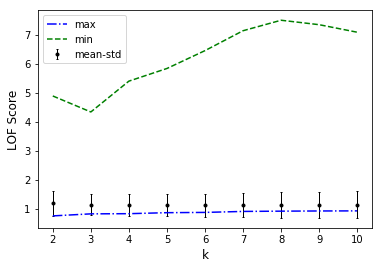

In [17]:
plt.figure(figsize = (6,4))
plt.errorbar(kL, meanL, stdL, fmt = '.k', lw = 1, capsize = 1, label = 'mean-std')
plt.plot(kL, minL, color = 'blue', linestyle = '-.', label = 'max')
plt.plot(kL, maxL, color = 'green', linestyle = '--', label = 'min')

plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('k', fontsize = 12)
plt.ylabel('LOF Score', fontsize = 12)
plt.legend()
plt.show()

### 3.2 데이터 특성(Application Dependent)
복수의 데이터들(특정 군집)에 대해 하나의 cluster로 볼 것인가 Local Outlier로 볼 것인지 정성적인 접근 방법에 따라 k-Neighborhood를 정하는 방법이다. 이 방법은 잘 사용하지 않는다.

In [19]:
plotDF = totDF.copy()

In [20]:
dateL = plotDF['data_index'].sort_values().unique().tolist()


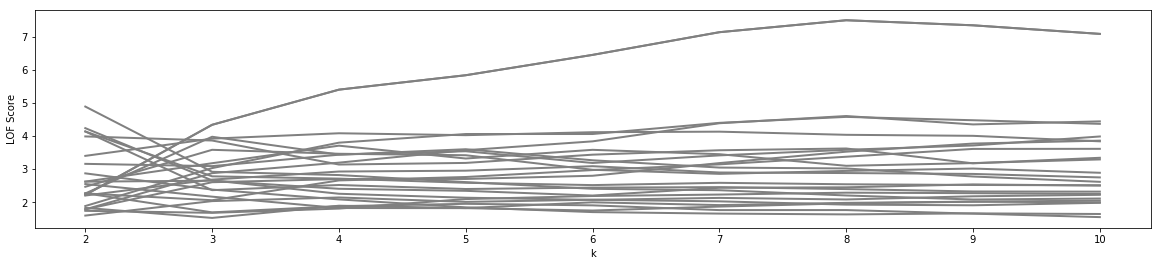

In [23]:
plt.figure(figsize = (20,4))
for dIter in dateL:
    pDF = plotDF.copy()
    pDF = pDF[pDF['data_index'] == dIter]
    pDF = pDF.sort_values('k')
    if pDF['lof_score'].min() >1.5:
        plt.plot(pDF['k'], pDF['lof_score'],
                color = 'gray',
                linewidth = 2)

plt.xlabel('k', fontsize = 10)
plt.ylabel('LOF Score', fontsize = 10)
plt.show()